
# Sex-biased tissues per perturbagen analysis- Cancer drugs
--------------------------------------------------------------------------------

Author: Belén Otero Carrasco

Last updated 26 february 2024


--------------------------------------------------------------------------------

In [1]:
import pkg_resources
# Print version of cmapPy being used in current conda environment 
pkg_resources.get_distribution("cmapPy").version

'4.0.1'

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from cmapPy.pandasGEXpress.parse import parse
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
from tqdm import tqdm

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Functions

In [3]:
def signatures_ids_perturbagen(drug):
    sig_pertu_ids = final_sig_original_filter["sig_id"][final_sig_original_filter["pert_iname"] == drug]
    print("number of samples treated with this perturbagen:")
    return sig_pertu_ids

In [4]:
def perturbagen_significant_genes(sig_pertu_ids,drug):
    perturbagen_genes_exp = parse("./Touchstone/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx", cid=sig_pertu_ids)
    df_perturbagen_genes_exp = perturbagen_genes_exp.data_df
    df_filter_significant = df_perturbagen_genes_exp[(df_perturbagen_genes_exp >2.0) | (df_perturbagen_genes_exp <-2.0)]
    df_bool_sign = df_filter_significant.notna()
    df_bool_sign["count"] = df_bool_sign.sum(axis=1)
    df_bool_sign = df_bool_sign.reset_index()
    df_gene_change = df_bool_sign[df_bool_sign["count"]> 0]
    df_gene_change_id = df_gene_change[["rid","count"]]
    df_gene_change_id["perturbagen_name"] = drug
    df_gene_change_id["Signature_id"] = sig_pertu_ids
    return df_gene_change_id 

In [5]:
def filter_by_tissue(tissue_type):
    data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")
    filtered_df_tissue = data_gtex[data_gtex["tissue"] == tissue_type]
    return filtered_df_tissue

In [6]:
def filter_by_ids_and_tissue(tissue_type):
    data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")
    data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")
    filtered_df_tissue_ids = data_gtex_filter[data_gtex_filter["tissue"] == tissue_type]
    return filtered_df_tissue_ids

In [33]:
def preprocesing_plot(dataframe,sig_cell_info):
  
    
    info_cell = sig_cell_info[["sig_id","Signature_id","cell_id","primary_site"]]
    info_cell = info_cell.drop_duplicates()
    clue_tiss_sig_gtex_ = dataframe.merge(info_tissue_cell, left_on=["Signature"],right_on=["sig_id"])
    clue_tiss_sig_gtex_['Significant'] = clue_tiss_sig_gtex_.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)
    
    return clue_tiss_sig_gtex_

In [70]:
def sex_biased_dir(dataframe):
    
    data_sig = clue_tiss_sig_gtex_[clue_tiss_sig_gtex_["Significant"]=="Yes"]
    df_genes_tiss_sb = data_sig.merge(df_all, left_on= ["sig_id","Perturbagen_name"], right_on=["Signature_id","perturbagen_name"], how ="inner")
    
    genes_female = df_all[df_all["Gene-bias"]== 3.0 ]
    genes_male = df_all[df_all["Gene-bias"]== 2.0]
    threshold = 0.05

    df_genes_sig = pd.DataFrame(columns = ["Signature","P-value","Significance","odds_ratio","Sex-biased","Number genes Male",
                                       "Number genes Female"])

    for sig_id in df_genes_tiss_sb["Signature"]:
        #print (sig_id)
        df_sig = df_genes_tiss_sb[df_genes_tiss_sb["Signature"] == sig_id]
    
       
        
        df_male_genes = df_tissue[df_tissue["Sex-bias"] == "Male"]
        df_female_genes = df_tissue[df_tissue["Sex-bias"] == "Female"]
        df_female_total = genes_female[genes_female["tissue"]== tissue]
        df_male_total = genes_male[genes_male["tissue"]== tissue]

        # Contar la frecuencia del suceso en cada caso
        frecuencia_c = len(df_male_genes)
        frecuencia_a = len(df_female_genes)
        frecuencia_d = len(df_male_total) - len(df_male_genes)
        frecuencia_b = len(df_female_total) - len(df_female_genes)
 
        # Create the contingency table
        contingency_table = [[frecuencia_a , frecuencia_b], [frecuencia_c , frecuencia_d]]
 
        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
 
        
            # Make a decision based on the p-value
            if p_value < threshold:
                #print('Reject the null hypothesis. There is a significant association.')
                p_value_label = "Yes" 
            else:
                #print('Insufficient evidence to reject the null hypothesis.')
                p_value_label = "No"
            #sex-biased 
            if p_value < threshold and frecuencia_c > frecuencia_a:
                #print("sex-biased male")
                sex_biased  = "sex-biased male"
            elif p_value < threshold and frecuencia_c < frecuencia_a:
                #print("sex-biased female")
                sex_biased  = "sex-biased female"
            else:
                #print("no sex-biased")
                sex_biased  = "no sex-biased differences"
            
            row = pd.DataFrame({"Signature": [sig_id],"Tissue_type":[tissue],"P-value": [p_value],"Significance": [p_value_label],"odds_ratio":[odds_ratio]
                            ,"Sex-biased": [sex_biased], "Number genes Male": [frecuencia_c],
                            "Number genes Female": [frecuencia_a]})
            df_genes_sig = pd.concat([df_genes_sig, row])
            
        df_genes_sig = df_genes_sig.drop_duplicates()
        df_general_plus_siggenes = clue_tiss_sig_gtex_.merge(df_genes_sig,on =["Signature","Tissue_type"], how="left" )
    
    
    return df_general_plus_siggenes
    

In [38]:
def assign_heatmap_value(row):
    if row["Significant"] == "Yes":
        if row["Equal tissue"]:
            if row["Sex-biased"] == "sex-biased male":
                return 7
            elif row["Sex-biased"] == "sex-biased female":
                return 6
            elif row["Sex-biased"] == "no sex-biased differences":
                return 5
        else:
            if row["Sex-biased"] == "sex-biased male":
                return 4
            elif row["Sex-biased"] == "sex-biased female":
                return 3
            elif row["Sex-biased"] == "no sex-biased differences":
                return 2
    return 1

In [36]:
def pivot_table_plot(df_general_plus_siggenes):
    
    clue_tiss_sig_gtex_pivot = df_general_plus_siggenes[["Signature_id","Tissue_type", "Heatmap_values"]]
    clue_tiss_sig_gtex_pivot = clue_tiss_sig_gtex_pivot.drop_duplicates()
    group_dis = clue_tiss_sig_gtex_pivot.pivot(index='Signature_id', columns='Tissue_type', values='Heatmap_values')
    
    return group_dis

In [37]:
def plot_heatmap(group_dis,drug):
    
    fig, ax = plt.subplots(figsize=(25, 25))
    ax = sns.heatmap(group_dis,linewidth=.5,cmap=["#FDEBD0","#82E0AA","#e65caa","#2EC7CE","#117A65","#910956","#175296"],vmin=1, vmax=7)
    colorbar = ax.collections[0].colorbar
    #colorbar.set_ticks([0, 1, 2])
    plt.title(f'Sex-biased tissues on {drug} application', fontsize = 20) # title with fontsize 20
    plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
    plt.tight_layout()
    plt.savefig(f"./images_sex-biased/heatmap_sig_tissue_{drug}.svg")
    # plt.show()
    return None 

### Signature information

In [8]:
## signatures unique per cell line by TAS and exemplar = 1 

In [6]:
sig_cell_info = pd.read_excel(("new_signame_tas_exemplar.xlsx"),engine='openpyxl')
sig_cell_info.head()

cell_id base_cell_id sample_type primary_site  \
0    A375         A375       tumor         skin   
1    A375         A375       tumor         skin   
2    A375         A375       tumor         skin   
3    A375         A375       tumor         skin   
4    A375         A375       tumor         skin   

                            tissue   abrev             subtype  \
0  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
1  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
2  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
3  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
4  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   

                                     sig_id                        pert_iname  \
0  CPC018_A375_6H:BRD-K06817181-001-01-5:10  1,2,3,4,5,6-hexabromocyclohexane   
1  CPC017_A375_6H:BRD-K74430258-001-01-2:10               1,2-dichlorobenzene   
2  CPC010_A375_6H:BRD-K32795028-001-10-9:10                 1-benzylimidazole   
3  CPC018_A375_6H:BRD-A80928489-001-01-0:10                    1-monopalmitin   
4  CPC018_A375_6H:BRD-K31491153-001-01-2:10                 1-phenylbiguanide   

        tas  is_exemplar                                Signature_id  
0  0.282354            1  1,2,3,4,5,6-hexabromocyclohexane_A375_skin  
1  0.057646            1               1,2-dichlorobenzene_A375_skin  
2  0.221885            1                 1-benzylimidazole_A375_skin  
3  0.118443            1                    1-monopalmitin_A375_skin  
4  0.313940            1                 1-phenylbiguanide_A375_skin

In [7]:
sig_cell_info_filter_site = sig_cell_info[(sig_cell_info["primary_site"]!= "ovary")
               & (sig_cell_info["primary_site"]!= "endometrium") & (sig_cell_info["primary_site"]!= "prostate")]
## deja mama porque en los de GTEX y puede estar en hombres tambien

In [8]:
cancer_drugs = pd.read_csv("drugs_cancer_clue.csv", sep=",")

In [9]:
drugs_ids = cancer_drugs[["pert_iname"]].drop_duplicates()

In [10]:
drugs_ids = drugs_ids.values.ravel().tolist()

In [44]:
mapping_tissue_GTEX_CLUE = pd.read_excel(("mapping_tissues_GTEX_CLUE.xlsx"),engine='openpyxl')

#### Gene (row) annotations 

In [11]:
gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
gene_info.columns

Index(['pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm',
       'pr_is_bing'],
      dtype='object')

In [12]:
pertub_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_info.txt", sep="\t", dtype=str)

In [13]:
per_metrics_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_metrics.txt", sep="\t", dtype=str)
per_metrics_id = per_metrics_id.replace({"-666":"Unknown"})

In [14]:
data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")

In [15]:
data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")

In [16]:
data_gtex['Sex-bias'] = data_gtex.apply(lambda row: 'Female' if row['effsize'] >= 0 else 'Male', axis=1)

In [17]:
data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")

In [18]:
pd.options.mode.chained_assignment = None 

In [53]:
data_gtex_tissues = data_gtex["tissue"].unique()

In [19]:
escape_genes = pd.read_excel(("escape_genes.xlsx"),engine='openpyxl')
escape_genes.head()

ENSEMBL_gene_id HUGO_gene_id  Sum of relative sex predictivity  \
0  ENSG00000229807.10         XIST                         27.913224   
1   ENSG00000270641.1         TSIX                         10.148605   
2  ENSG00000147050.14        KDM6A                          0.953643   
3  ENSG00000005889.15          ZFX                          0.571802   
4  ENSG00000198034.10        RPS4X                          0.437481   

   Avg of relative sex predictivity (*100)  #Tissues predictivity  \
0                                63.439145                   44.0   
1                                23.601408                   43.0   
2                                 3.405867                   28.0   
3                                 1.681771                   34.0   
4                                 2.083242                   21.0   

   Female-biased  Male-biased  Female-biased (median)  Male-biased (median)  \
0             44            0                   9.514                   NaN   
1              1            0                   7.480                   NaN   
2             44            0                   0.636                   NaN   
3             44            0                   0.581                   NaN   
4             44            0                   0.485                   NaN   

   Reported Escapee?  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [20]:
escape_genes_filter = escape_genes.copy()

In [21]:
escape_genes_filter.loc[escape_genes_filter['Male-biased'] > escape_genes_filter['Female-biased'], 'Gene-bias'] = 2
escape_genes_filter.loc[escape_genes_filter['Male-biased'] < escape_genes_filter['Female-biased'], 'Gene-bias'] = 3
escape_genes_filter.loc[escape_genes_filter['Male-biased'] == escape_genes_filter['Female-biased'], 'Gene-bias'] = 1

In [24]:
len(escape_genes_filter["HUGO_gene_id"].unique())

531

In [25]:
escape_genes_filter

ENSEMBL_gene_id HUGO_gene_id  Sum of relative sex predictivity  \
0    ENSG00000229807.10         XIST                         27.913224   
1     ENSG00000270641.1         TSIX                         10.148605   
2    ENSG00000147050.14        KDM6A                          0.953643   
3    ENSG00000005889.15          ZFX                          0.571802   
4    ENSG00000198034.10        RPS4X                          0.437481   
..                  ...          ...                               ...   
526  ENSG00000124333.15        VAMP7                               NaN   
527   ENSG00000223571.6    DHRSX-IT1                               NaN   
528  ENSG00000182508.13       LHFPL1                               NaN   
529  ENSG00000189108.12     IL1RAPL2                               NaN   
530   ENSG00000155622.6        XAGE2                               NaN   

     Avg of relative sex predictivity (*100)  #Tissues predictivity  \
0                                  63.439145                   44.0   
1                                  23.601408                   43.0   
2                                   3.405867                   28.0   
3                                   1.681771                   34.0   
4                                   2.083242                   21.0   
..                                       ...                    ...   
526                                      NaN                    NaN   
527                                      NaN                    NaN   
528                                      NaN                    NaN   
529                                      NaN                    NaN   
530                                      NaN                    NaN   

     Female-biased  Male-biased  Female-biased (median)  Male-biased (median)  \
0               44            0                   9.514                   NaN   
1                1            0                   7.480                   NaN   
2               44            0                   0.636                   NaN   
3               44            0                   0.581                   NaN   
4               44            0                   0.485                   NaN   
..             ...          ...                     ...                   ...   
526              0            5                     NaN                -0.014   
527              0            1                     NaN                -0.641   
528              0            3                     NaN                -0.073   
529              1            0                   0.381                   NaN   
530              2            1                   0.395                -0.357   

     Reported Escapee?  Gene-bias  
0                    1        3.0  
1                    1        3.0  
2                    1        3.0  
3                    1        3.0  
4                    1        3.0  
..                 ...        ...  
526                  0        2.0  
527                  0        2.0  
528                  0        2.0  
529                  1        3.0  
530                  0        3.0  

[531 rows x 11 columns]

In [54]:
#drugs_ids_check = ["sirolimus"]

In [78]:
signatures_per_perturbagen = []
genes_significant_per_perturbagen = []
p_values_per_tissue_perturbagen = []
df = pd.DataFrame(columns=["Signature","Perturbagen_name", "P-value" ])
overlap_genes = []

for drug in tqdm(drugs_ids):
    print(drug)
    sig_pertu_ids = sig_cell_info_filter_site["sig_id"][sig_cell_info_filter_site["pert_iname"] == drug]
    sig_pertu_ids = sig_pertu_ids.drop_duplicates()
    print (len(sig_pertu_ids))
    signatures_per_perturbagen.append(sig_pertu_ids)
    
    for num_sig, sig in enumerate(sig_pertu_ids): 
        #print (num_sig, sig)
        genes_significant = perturbagen_significant_genes(sig,drug)
        gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
        genes_sig_per_pertur = genes_significant.merge(gene_info, left_on="rid", right_on="pr_gene_id")
        genes_sig_per_pertur = genes_sig_per_pertur[["perturbagen_name","Signature_id","pr_gene_id","pr_gene_symbol"]]
        genes_significant_per_perturbagen.append(genes_sig_per_pertur)

        
        overlap = genes_sig_per_pertur.merge(escape_genes_filter,left_on= "pr_gene_symbol",right_on="HUGO_gene_id")
        overlap = overlap[["perturbagen_name","Signature_id","HUGO_gene_id","Gene-bias"]]
        overlap_genes.append(overlap)
        df_all = pd.concat(overlap_genes)

        # parameters
        population_total = 20000 
        num_genes_change_expression_perturbagen = len(genes_sig_per_pertur)  # Number of genes clue significant
        num_genes_escap = len(escape_genes_filter) # GTEX tissue type n-genes
        overlap_len = len(overlap)  #overlap
        #test 
        #resultado = hypergeom.sf(overlap - 1, population_total, num_genes_change_expression_perturbagen, num_genes_gtex_tissue)
        result = hypergeom.sf(overlap_len - 1, population_total,num_genes_escap,num_genes_change_expression_perturbagen)
        p_values_per_tissue_perturbagen.append(result)
        #print("P-value:", resultado, tissue, drug)
        row = pd.DataFrame({"P-value": [result], "Perturbagen_name": [drug],"Signature":[sig]})
        df = pd.concat([df, row])
        
    

    
    

  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

idarubicin
37


  1%|▊                                                                                  | 1/95 [00:14<23:16, 14.85s/it]

rucaparib
38


  2%|█▋                                                                                 | 2/95 [00:30<23:19, 15.05s/it]

afatinib
15


  3%|██▌                                                                                | 3/95 [00:36<18:57, 12.36s/it]

celecoxib
13


  4%|███▍                                                                               | 4/95 [00:41<15:33, 10.25s/it]

exemestane
11


  5%|████▎                                                                              | 5/95 [00:46<12:47,  8.53s/it]

mercaptopurine
5


  6%|█████▏                                                                             | 6/95 [00:48<09:46,  6.59s/it]

cyclophosphamide
6


  7%|██████                                                                             | 7/95 [00:50<07:51,  5.36s/it]

decitabine
12


  8%|██████▉                                                                            | 8/95 [00:55<07:35,  5.24s/it]

temsirolimus
38


  9%|███████▊                                                                           | 9/95 [01:11<11:56,  8.33s/it]

goserelin
7


 11%|████████▋                                                                         | 10/95 [01:14<09:30,  6.71s/it]

vemurafenib
48


 12%|█████████▍                                                                        | 11/95 [01:34<14:57, 10.69s/it]

pirfenidone
11


 13%|██████████▎                                                                       | 12/95 [01:38<12:18,  8.89s/it]

nilutamide
11


 14%|███████████▏                                                                      | 13/95 [01:43<10:24,  7.62s/it]

tivozanib
43


 15%|████████████                                                                      | 14/95 [02:02<14:41, 10.88s/it]

axitinib
11


 16%|████████████▉                                                                     | 15/95 [02:06<12:03,  9.05s/it]

procarbazine
11


 17%|█████████████▊                                                                    | 16/95 [02:11<10:11,  7.75s/it]

formestane
11


 18%|██████████████▋                                                                   | 17/95 [02:16<08:54,  6.85s/it]

sorafenib
18


 19%|███████████████▌                                                                  | 18/95 [02:24<09:09,  7.13s/it]

fulvestrant
12


 20%|████████████████▍                                                                 | 19/95 [02:29<08:20,  6.59s/it]

anastrozole
7


 21%|█████████████████▎                                                                | 20/95 [02:32<06:54,  5.52s/it]

dasatinib
15


 22%|██████████████████▏                                                               | 21/95 [02:39<07:12,  5.85s/it]

letrozole
5


 23%|██████████████████▉                                                               | 22/95 [02:41<05:45,  4.73s/it]

altretamine
11


 24%|███████████████████▊                                                              | 23/95 [02:47<06:05,  5.08s/it]

azacitidine
6


 25%|████████████████████▋                                                             | 24/95 [02:50<05:29,  4.65s/it]

azathioprine
5


 26%|█████████████████████▌                                                            | 25/95 [02:58<06:28,  5.55s/it]

dactinomycin
10


 27%|██████████████████████▍                                                           | 26/95 [03:14<09:53,  8.60s/it]

vinblastine
13


 28%|███████████████████████▎                                                          | 27/95 [03:26<10:55,  9.64s/it]

cladribine
7


 29%|████████████████████████▏                                                         | 28/95 [03:29<08:33,  7.67s/it]

toremifene
11


 31%|█████████████████████████                                                         | 29/95 [03:34<07:31,  6.84s/it]

mitotane
11


 32%|█████████████████████████▉                                                        | 30/95 [03:39<06:50,  6.32s/it]

clofarabine
11


 33%|██████████████████████████▊                                                       | 31/95 [03:45<06:35,  6.18s/it]

capecitabine
11


 34%|███████████████████████████▌                                                      | 32/95 [03:50<06:13,  5.92s/it]

daunorubicin
17


 35%|████████████████████████████▍                                                     | 33/95 [03:59<07:03,  6.83s/it]

ruxolitinib
17


 36%|█████████████████████████████▎                                                    | 34/95 [04:08<07:33,  7.44s/it]

neratinib
44


 37%|██████████████████████████████▏                                                   | 35/95 [04:28<11:15, 11.25s/it]

palbociclib
17


 38%|███████████████████████████████                                                   | 36/95 [04:36<10:03, 10.23s/it]

everolimus
12


 39%|███████████████████████████████▉                                                  | 37/95 [04:41<08:30,  8.80s/it]

tegafur
5


 40%|████████████████████████████████▊                                                 | 38/95 [04:43<06:30,  6.84s/it]

sonidegib
38


 41%|█████████████████████████████████▋                                                | 39/95 [05:01<09:21, 10.03s/it]

ixazomib
40


 42%|██████████████████████████████████▌                                               | 40/95 [05:20<11:33, 12.61s/it]

tofacitinib
11


 43%|███████████████████████████████████▍                                              | 41/95 [05:25<09:19, 10.37s/it]

raltitrexed
11


 44%|████████████████████████████████████▎                                             | 42/95 [05:30<07:45,  8.79s/it]

vindesine
4


 45%|█████████████████████████████████████                                             | 43/95 [05:32<05:49,  6.71s/it]

abiraterone
6


 46%|█████████████████████████████████████▉                                            | 44/95 [05:34<04:42,  5.54s/it]

nilotinib
17


 47%|██████████████████████████████████████▊                                           | 45/95 [05:42<05:14,  6.28s/it]

tacrolimus
42


 48%|███████████████████████████████████████▋                                          | 46/95 [06:02<08:26, 10.34s/it]

bosutinib
13


 49%|████████████████████████████████████████▌                                         | 47/95 [06:08<07:16,  9.09s/it]

methotrexate
6


 51%|█████████████████████████████████████████▍                                        | 48/95 [06:11<05:40,  7.24s/it]

docetaxel
9


 52%|██████████████████████████████████████████▎                                       | 49/95 [06:16<04:52,  6.36s/it]

tretinoin
46


 53%|███████████████████████████████████████████▏                                      | 50/95 [06:38<08:16, 11.03s/it]

belinostat
11


 54%|████████████████████████████████████████████                                      | 51/95 [06:43<06:49,  9.31s/it]

bicalutamide
11


 55%|████████████████████████████████████████████▉                                     | 52/95 [06:49<06:02,  8.43s/it]

diethylstilbestrol
11


 56%|█████████████████████████████████████████████▋                                    | 53/95 [06:55<05:15,  7.50s/it]

sirolimus
49


 57%|██████████████████████████████████████████████▌                                   | 54/95 [07:19<08:35, 12.57s/it]

epirubicin
13


 58%|███████████████████████████████████████████████▍                                  | 55/95 [07:25<07:08, 10.71s/it]

paclitaxel
14


 59%|████████████████████████████████████████████████▎                                 | 56/95 [07:32<06:11,  9.53s/it]

amsacrine
11


 60%|█████████████████████████████████████████████████▏                                | 57/95 [07:38<05:14,  8.27s/it]

etoposide
8


 61%|██████████████████████████████████████████████████                                | 58/95 [07:41<04:17,  6.97s/it]

teniposide
42


 62%|██████████████████████████████████████████████████▉                               | 59/95 [08:02<06:38, 11.06s/it]

thalidomide
44


 63%|███████████████████████████████████████████████████▊                              | 60/95 [08:24<08:19, 14.28s/it]

pazopanib
17


 64%|████████████████████████████████████████████████████▋                             | 61/95 [08:32<07:07, 12.57s/it]

irinotecan
11


 65%|█████████████████████████████████████████████████████▌                            | 62/95 [08:38<05:44, 10.45s/it]

panobinostat
13


 66%|██████████████████████████████████████████████████████▍                           | 63/95 [08:44<04:56,  9.26s/it]

aminoglutethimide
11


 67%|███████████████████████████████████████████████████████▏                          | 64/95 [08:50<04:11,  8.11s/it]

chlorambucil
11


 68%|████████████████████████████████████████████████████████                          | 65/95 [08:55<03:40,  7.34s/it]

olaparib
38


 69%|████████████████████████████████████████████████████████▉                         | 66/95 [09:15<05:15, 10.87s/it]

doxorubicin
10


 71%|█████████████████████████████████████████████████████████▊                        | 67/95 [09:20<04:15,  9.12s/it]

sunitinib
12


 72%|██████████████████████████████████████████████████████████▋                       | 68/95 [09:26<03:42,  8.25s/it]

erlotinib
17


 73%|███████████████████████████████████████████████████████████▌                      | 69/95 [09:35<03:44,  8.65s/it]

vinorelbine
12


 74%|████████████████████████████████████████████████████████████▍                     | 70/95 [09:42<03:20,  8.03s/it]

lapatinib
16


 75%|█████████████████████████████████████████████████████████████▎                    | 71/95 [09:50<03:15,  8.15s/it]

mitoxantrone
8


 76%|██████████████████████████████████████████████████████████████▏                   | 72/95 [09:55<02:39,  6.95s/it]

crizotinib
17


 77%|███████████████████████████████████████████████████████████████                   | 73/95 [10:03<02:46,  7.55s/it]

midostaurin
11


 78%|███████████████████████████████████████████████████████████████▊                  | 74/95 [10:09<02:28,  7.07s/it]

thiotepa
11


 79%|████████████████████████████████████████████████████████████████▋                 | 75/95 [10:15<02:13,  6.66s/it]

alitretinoin
13


 80%|█████████████████████████████████████████████████████████████████▌                | 76/95 [10:22<02:08,  6.78s/it]

anagrelide
11


 81%|██████████████████████████████████████████████████████████████████▍               | 77/95 [10:28<01:55,  6.44s/it]

cytarabine
8


 82%|███████████████████████████████████████████████████████████████████▎              | 78/95 [10:32<01:37,  5.76s/it]

flutamide
43


 83%|████████████████████████████████████████████████████████████████████▏             | 79/95 [10:55<02:56, 11.03s/it]

temozolomide
41


 84%|█████████████████████████████████████████████████████████████████████             | 80/95 [11:17<03:34, 14.27s/it]

busulfan
6


 85%|█████████████████████████████████████████████████████████████████████▉            | 81/95 [11:20<02:33, 10.96s/it]

tamoxifen
45


 86%|██████████████████████████████████████████████████████████████████████▊           | 82/95 [11:44<03:12, 14.81s/it]

topotecan
11


 87%|███████████████████████████████████████████████████████████████████████▋          | 83/95 [11:50<02:26, 12.18s/it]

lenalidomide
43


 88%|████████████████████████████████████████████████████████████████████████▌         | 84/95 [12:14<02:52, 15.68s/it]

gemcitabine
35


 89%|█████████████████████████████████████████████████████████████████████████▎        | 85/95 [12:33<02:45, 16.59s/it]

vincristine
10


 91%|██████████████████████████████████████████████████████████████████████████▏       | 86/95 [12:38<01:59, 13.25s/it]

floxuridine
10


 92%|███████████████████████████████████████████████████████████████████████████       | 87/95 [12:44<01:27, 10.91s/it]

gefitinib
17


 93%|███████████████████████████████████████████████████████████████████████████▉      | 88/95 [12:53<01:13, 10.44s/it]

imatinib
17


 94%|████████████████████████████████████████████████████████████████████████████▊     | 89/95 [13:02<01:00, 10.10s/it]

leflunomide
11


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 90/95 [13:09<00:44,  8.98s/it]

vorinostat
48


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 91/95 [13:35<00:57, 14.28s/it]

streptozotocin
6


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 92/95 [13:39<00:32, 11.00s/it]

homoharringtonine
11


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 93/95 [13:45<00:19,  9.52s/it]

5-aminolevulinic-acid
6


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 94/95 [13:48<00:07,  7.68s/it]

medroxyprogesterone
6


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [13:51<00:00,  8.76s/it]


In [80]:
df

Signature     Perturbagen_name   P-value
0     CPC011_A375_6H:BRD-K69650333-003-11-6:10           idarubicin  0.899871
0     CPC011_A549_6H:BRD-K69650333-003-11-6:10           idarubicin  0.012220
0   CPC006_A673_6H:BRD-A71390734-001-01-7:0.08           idarubicin  0.442725
0    CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08           idarubicin  0.855082
0   CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08           idarubicin  0.831179
..                                         ...                  ...       ...
0     CPC020_A549_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  0.443174
0     CPC020_HA1E_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0   CPC020_HCC515_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  0.580988
0     CPC020_HT29_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0     CPC020_MCF7_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000

[1663 rows x 3 columns]

In [81]:
df_all

perturbagen_name                                Signature_id  \
0            idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
1            idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
2            idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
3            idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
4            idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
..                  ...                                         ...   
0   medroxyprogesterone    CPC020_A549_6H:BRD-K82216340-001-19-7:10   
1   medroxyprogesterone    CPC020_A549_6H:BRD-K82216340-001-19-7:10   
2   medroxyprogesterone    CPC020_A549_6H:BRD-K82216340-001-19-7:10   
0   medroxyprogesterone  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10   
1   medroxyprogesterone  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10   

   HUGO_gene_id  Gene-bias  
0       SUV39H1        3.0  
1         PHKA1        3.0  
2       IL13RA1        3.0  
3          SSR4        3.0  
4        TSPAN7        3.0  
..          ...        ...  
0       TSC22D3        3.0  
1           MSN        2.0  
2       SLC25A6        2.0  
0       TSC22D3        3.0  
1         TIMP1        2.0  

[23921 rows x 4 columns]

In [82]:
info_cell = sig_cell_info[["sig_id","Signature_id","cell_id"]]
info_cell = info_cell.drop_duplicates()

In [83]:
info_cell

sig_id  \
0       CPC018_A375_6H:BRD-K06817181-001-01-5:10   
1       CPC017_A375_6H:BRD-K74430258-001-01-2:10   
2       CPC010_A375_6H:BRD-K32795028-001-10-9:10   
3       CPC018_A375_6H:BRD-A80928489-001-01-0:10   
4       CPC018_A375_6H:BRD-K31491153-001-01-2:10   
...                                          ...   
258599        KDB008_SKL_96H:TRCN0000020197:-666   
258600        KDB002_SKL_96H:TRCN0000236645:-666   
258601        KDB001_SKL_96H:TRCN0000150938:-666   
258602        KDB007_SKL_96H:TRCN0000072242:-666   
258603        KDB008_SKL_96H:TRCN0000145620:-666   

                                      Signature_id cell_id  
0       1,2,3,4,5,6-hexabromocyclohexane_A375_skin    A375  
1                    1,2-dichlorobenzene_A375_skin    A375  
2                      1-benzylimidazole_A375_skin    A375  
3                         1-monopalmitin_A375_skin    A375  
4                      1-phenylbiguanide_A375_skin    A375  
...                                            ...     ...  
258599                           ZNF589_SKL_muscle     SKL  
258600                           ZNF629_SKL_muscle     SKL  
258601                             ZW10_SKL_muscle     SKL  
258602                             lacZ_SKL_muscle     SKL  
258603                              pgw_SKL_muscle     SKL  

[173142 rows x 3 columns]

In [84]:
clue_tiss_sig_gtex_ = df.merge(info_cell, left_on=["Signature"],right_on=["sig_id"])
clue_tiss_sig_gtex_['Significant'] = clue_tiss_sig_gtex_.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)

In [85]:
clue_tiss_sig_gtex_

Signature     Perturbagen_name  \
0       CPC011_A375_6H:BRD-K69650333-003-11-6:10           idarubicin   
1       CPC011_A549_6H:BRD-K69650333-003-11-6:10           idarubicin   
2     CPC006_A673_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
3      CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
4     CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
...                                          ...                  ...   
1658    CPC020_A549_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1659    CPC020_HA1E_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1660  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1661    CPC020_HT29_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1662    CPC020_MCF7_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   

       P-value                                      sig_id  \
0     0.899871    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
1     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
2     0.442725  CPC006_A673_6H:BRD-A71390734-001-01-7:0.08   
3     0.855082   CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08   
4     0.831179  CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08   
...        ...                                         ...   
1658  0.443174    CPC020_A549_6H:BRD-K82216340-001-19-7:10   
1659  1.000000    CPC020_HA1E_6H:BRD-K82216340-001-19-7:10   
1660  0.580988  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10   
1661  1.000000    CPC020_HT29_6H:BRD-K82216340-001-19-7:10   
1662  1.000000    CPC020_MCF7_6H:BRD-K82216340-001-19-7:10   

                                  Signature_id cell_id Significant  
0                         idarubicin_A375_skin    A375          No  
1                         idarubicin_A549_lung    A549         Yes  
2                         idarubicin_A673_bone    A673          No  
3                       idarubicin_AGS_stomach     AGS          No  
4              idarubicin_CL34_large intestine    CL34          No  
...                                        ...     ...         ...  
1658             medroxyprogesterone_A549_lung    A549          No  
1659           medroxyprogesterone_HA1E_kidney    HA1E          No  
1660           medroxyprogesterone_HCC515_lung  HCC515          No  
1661  medroxyprogesterone_HT29_large intestine    HT29          No  
1662           medroxyprogesterone_MCF7_breast    MCF7          No  

[1663 rows x 7 columns]

In [86]:
data_sig = clue_tiss_sig_gtex_[clue_tiss_sig_gtex_["Significant"]=="Yes"]   

In [87]:
data_sig

Signature       Perturbagen_name  \
1         CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
33     CPC006_T3M10_6H:BRD-A71390734-001-01-7:0.08             idarubicin   
42      CPC006_CORL23_6H:BRD-K88560311-011-02-2:10              rucaparib   
59       CPC006_NOMO1_6H:BRD-K88560311-011-02-2:10              rucaparib   
83     LJP002_MCF10A_24H:BRD-A58767537-001-01-2:10               afatinib   
...                                            ...                    ...   
1469  CPC006_SKLU1_6H:BRD-A17883755-001-02-0:177.6           lenalidomide   
1543      LJP002_BT20_6H:BRD-K64052750-001-08-4:10              gefitinib   
1572   NMH002_FIBRNPC_6H:BRD-K92723993-066-14-4:10               imatinib   
1604    HDAC002_MCF7_24H:BRD-K81418486-001-24-4:10             vorinostat   
1654    CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   

       P-value                                        sig_id  \
1     0.012220      CPC011_A549_6H:BRD-K69650333-003-11-6:10   
33    0.026053   CPC006_T3M10_6H:BRD-A71390734-001-01-7:0.08   
42    0.017453    CPC006_CORL23_6H:BRD-K88560311-011-02-2:10   
59    0.027374     CPC006_NOMO1_6H:BRD-K88560311-011-02-2:10   
83    0.042561   LJP002_MCF10A_24H:BRD-A58767537-001-01-2:10   
...        ...                                           ...   
1469  0.048612  CPC006_SKLU1_6H:BRD-A17883755-001-02-0:177.6   
1543  0.043654      LJP002_BT20_6H:BRD-K64052750-001-08-4:10   
1572  0.033941   NMH002_FIBRNPC_6H:BRD-K92723993-066-14-4:10   
1604  0.028829    HDAC002_MCF7_24H:BRD-K81418486-001-24-4:10   
1654  0.027782    CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   

                                           Signature_id  cell_id Significant  
1                                  idarubicin_A549_lung     A549         Yes  
33                                idarubicin_T3M10_lung    T3M10         Yes  
42                                rucaparib_CORL23_lung   CORL23         Yes  
59    rucaparib_NOMO1_haematopoietic and lymphoid ti...    NOMO1         Yes  
83                               afatinib_MCF10A_breast   MCF10A         Yes  
...                                                 ...      ...         ...  
1469                            lenalidomide_SKLU1_lung    SKLU1         Yes  
1543                              gefitinib_BT20_breast     BT20         Yes  
1572                              imatinib_FIBRNPC_skin  FIBRNPC         Yes  
1604                             vorinostat_MCF7_breast     MCF7         Yes  
1654                  5-aminolevulinic-acid_HCC515_lung   HCC515         Yes  

[86 rows x 7 columns]

In [88]:
df_genes_tiss_sb = data_sig.merge(df_all, left_on= ["sig_id","Perturbagen_name"], right_on=["Signature_id","perturbagen_name"], how ="inner")

In [89]:
df_genes_tiss_sb

Signature       Perturbagen_name  \
0       CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
1       CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
2       CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
3       CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
4       CPC011_A549_6H:BRD-K69650333-003-11-6:10             idarubicin   
...                                          ...                    ...   
4106  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   
4107  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   
4108  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   
4109  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   
4110  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10  5-aminolevulinic-acid   

       P-value                                      sig_id  \
0     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
1     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
2     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
3     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
4     0.012220    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
...        ...                                         ...   
4106  0.027782  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4107  0.027782  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4108  0.027782  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4109  0.027782  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4110  0.027782  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   

                         Signature_id_x cell_id Significant  \
0                  idarubicin_A549_lung    A549         Yes   
1                  idarubicin_A549_lung    A549         Yes   
2                  idarubicin_A549_lung    A549         Yes   
3                  idarubicin_A549_lung    A549         Yes   
4                  idarubicin_A549_lung    A549         Yes   
...                                 ...     ...         ...   
4106  5-aminolevulinic-acid_HCC515_lung  HCC515         Yes   
4107  5-aminolevulinic-acid_HCC515_lung  HCC515         Yes   
4108  5-aminolevulinic-acid_HCC515_lung  HCC515         Yes   
4109  5-aminolevulinic-acid_HCC515_lung  HCC515         Yes   
4110  5-aminolevulinic-acid_HCC515_lung  HCC515         Yes   

           perturbagen_name                              Signature_id_y  \
0                idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
1                idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
2                idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
3                idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
4                idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
...                     ...                                         ...   
4106  5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4107  5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4108  5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4109  5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4110  5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   

     HUGO_gene_id  Gene-bias  
0            PRKX        3.0  
1           FOXO4        1.0  
2          DYNLT3        2.0  
3            PGK1        3.0  
4          BCAP31        3.0  
...           ...        ...  
4106         NXF3        2.0  
4107        GDPD2        2.0  
4108        PRRG3        3.0  
4109        SAGE1        3.0  
4110         SYN1        1.0  

[4111 rows x 11 columns]

In [90]:
df_genes_tiss_sb_fil = df_genes_tiss_sb[["Signature_id_x","Gene-bias"]]

In [91]:
df_genes_tiss_sb_fil

Signature_id_x  Gene-bias
0                  idarubicin_A549_lung        3.0
1                  idarubicin_A549_lung        1.0
2                  idarubicin_A549_lung        2.0
3                  idarubicin_A549_lung        3.0
4                  idarubicin_A549_lung        3.0
...                                 ...        ...
4106  5-aminolevulinic-acid_HCC515_lung        2.0
4107  5-aminolevulinic-acid_HCC515_lung        2.0
4108  5-aminolevulinic-acid_HCC515_lung        3.0
4109  5-aminolevulinic-acid_HCC515_lung        3.0
4110  5-aminolevulinic-acid_HCC515_lung        1.0

[4111 rows x 2 columns]

In [92]:
# Agrupar por ID y obtener la categoría con el mayor conteo para cada ID
max_category_by_id = df_genes_tiss_sb_fil.groupby('Signature_id_x')['Gene-bias'].apply(lambda x: x.value_counts().idxmax())

# Convertir la serie resultante en un DataFrame
result_df = max_category_by_id.reset_index(name='Gene-bias')

In [93]:
result_df

Signature_id_x  Gene-bias
0      5-aminolevulinic-acid_HCC515_lung        3.0
1                 afatinib_MCF10A_breast        3.0
2          aminoglutethimide_HCC515_lung        2.0
3                   anagrelide_A549_lung        3.0
4                   axitinib_NEU_Unknown        3.0
..                                   ...        ...
81  topotecan_NPC_central nervous system        3.0
82                   tretinoin_A549_lung        3.0
83      vemurafenib_HT29_large intestine        3.0
84               vemurafenib_SKMEL1_skin        2.0
85                vorinostat_MCF7_breast        3.0

[86 rows x 2 columns]

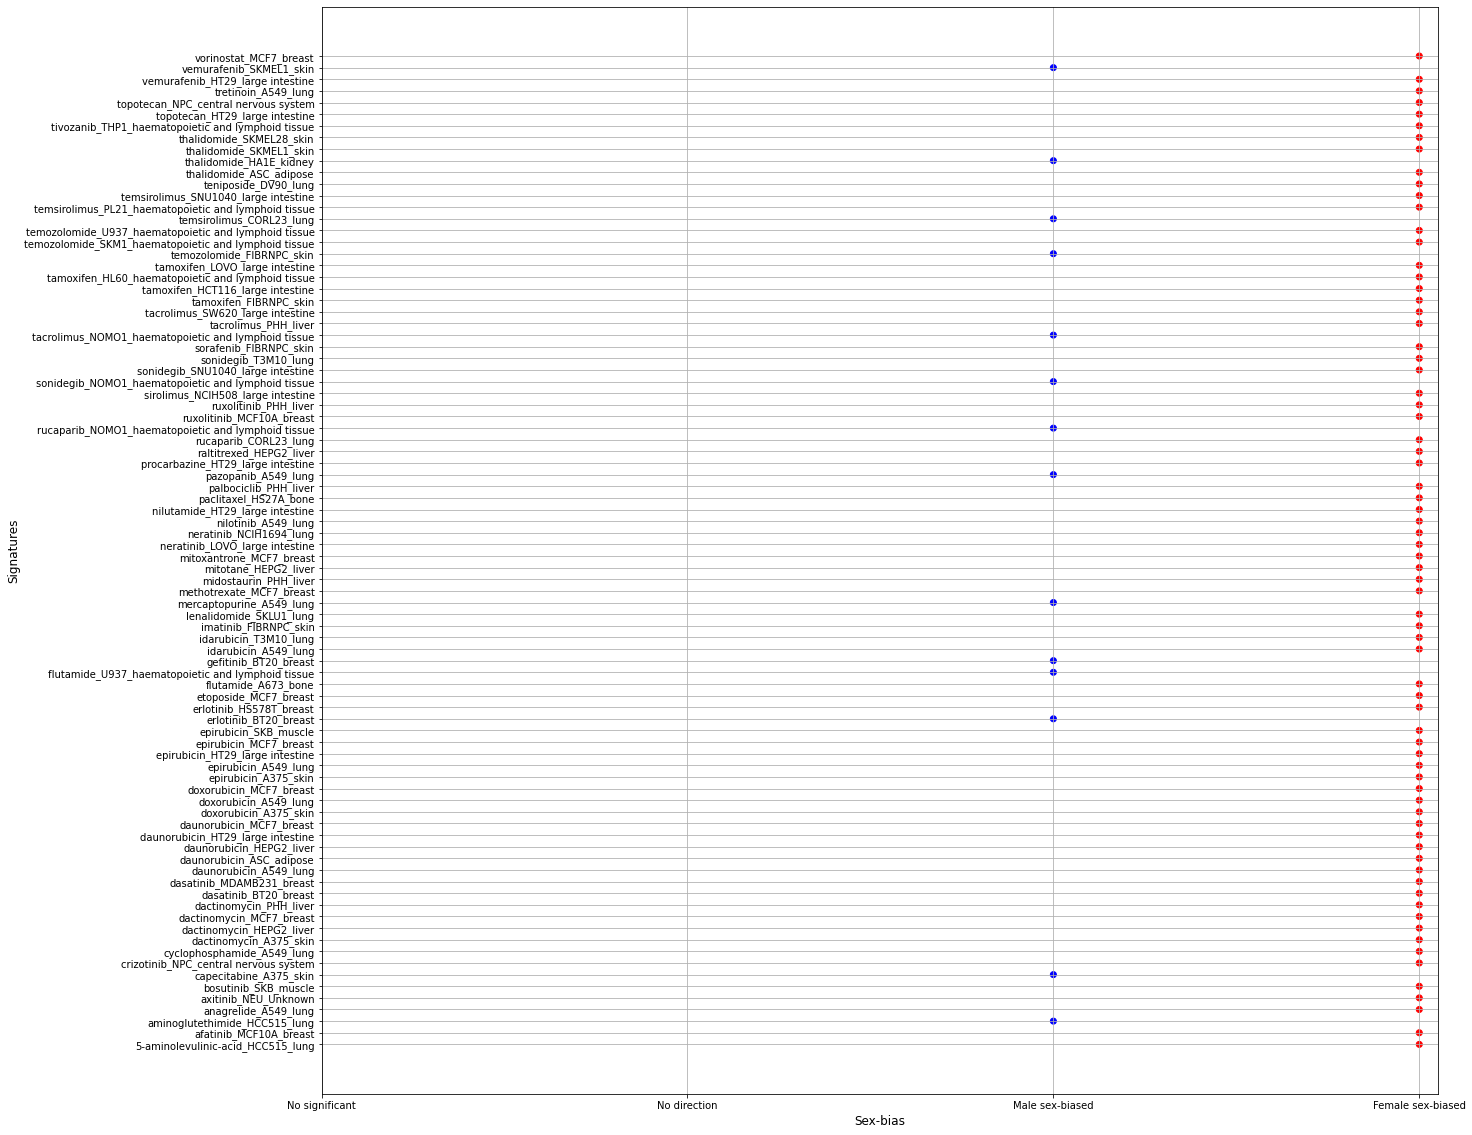

In [98]:
# Define the colors for each category
category_colors = {
    0: 'yellow',             # No significant
    1: 'green',            # No direction
    2: 'blue',           # Male sex-biased
    3: 'red'               # Female sex-biased
}
fig, ax = plt.subplots(figsize=(20, 20))
# Plot the scatter plot with colors based on category
plt.scatter(result_df['Gene-bias'], result_df['Signature_id_x'], c=result_df['Gene-bias'].map(category_colors))
plt.xlabel('Sex-bias',fontsize = 12)
plt.ylabel('Signatures',fontsize = 12)
plt.xticks(range(4), ['No significant', 'No direction', 'Male sex-biased', 'Female sex-biased'])  # Set x-axis labels
plt.grid(True)
plt.show()


In [53]:
df

IDs  Categorias
0  101           0
1  102           1
2  103           2
3  104           0
4  105           3

In [ ]:
clue_tiss_sig_gtex_pivot = df_genes_tiss_sb[["Signature_id_x","Tissue_type", "Heatmap_values"]]
    

In [ ]:
clue_tiss_sig_gtex_pivot = clue_tiss_sig_gtex_pivot.drop_duplicates()
    group_dis = clue_tiss_sig_gtex_pivot.pivot(index='Signature_id', columns='Tissue_type', values='Heatmap_values')

In [45]:
genes_female = df_all[df_all["Gene-bias"]== 3.0]
genes_male = df_all[df_all["Gene-bias"]== 2.0]

In [49]:
genes_female

perturbagen_name                              Signature_id HUGO_gene_id  \
0        idarubicin  CPC011_A375_6H:BRD-K69650333-003-11-6:10      SUV39H1   
1        idarubicin  CPC011_A375_6H:BRD-K69650333-003-11-6:10        PHKA1   
2        idarubicin  CPC011_A375_6H:BRD-K69650333-003-11-6:10      IL13RA1   
3        idarubicin  CPC011_A375_6H:BRD-K69650333-003-11-6:10         SSR4   
4        idarubicin  CPC011_A375_6H:BRD-K69650333-003-11-6:10       TSPAN7   
..              ...                                       ...          ...   
5          afatinib  CPC013_SKB_24H:BRD-K66175015-001-01-7:10        IGBP1   
7          afatinib  CPC013_SKB_24H:BRD-K66175015-001-01-7:10         RBM3   
9          afatinib  CPC013_SKB_24H:BRD-K66175015-001-01-7:10       DIAPH2   
10         afatinib  CPC013_SKB_24H:BRD-K66175015-001-01-7:10        RENBP   
11         afatinib  CPC013_SKB_24H:BRD-K66175015-001-01-7:10        GRIA3   

    Gene-bias  
0         3.0  
1         3.0  
2         3.0  
3         3.0  
4         3.0  
..        ...  
5         3.0  
7         3.0  
9         3.0  
10        3.0  
11        3.0  

[503 rows x 4 columns]

In [47]:
df_genes_sig = pd.DataFrame(columns = ["Signature","P-value","Significance","odds_ratio","Sex-biased","Number genes Male",
                                       "Number genes Female"])


In [48]:
df_genes_sig

Empty DataFrame
Columns: [Signature, P-value, Significance, odds_ratio, Sex-biased, Number genes Male, Number genes Female]
Index: []

In [ ]:
  for sig_id in df_genes_tiss_sb["Signature"]:
        #print (sig_id)
        df_sig = df_genes_tiss_sb[df_genes_tiss_sb["Signature"] == sig_id]
    
       
        
        df_male_genes = df_tissue[df_tissue["Sex-bias"] == "Male"]
        df_female_genes = df_tissue[df_tissue["Sex-bias"] == "Female"]
        df_female_total = genes_female[genes_female["tissue"]== tissue]
        df_male_total = genes_male[genes_male["tissue"]== tissue]

        # Contar la frecuencia del suceso en cada caso
        frecuencia_c = len(df_male_genes)
        frecuencia_a = len(df_female_genes)
        frecuencia_d = len(df_male_total) - len(df_male_genes)
        frecuencia_b = len(df_female_total) - len(df_female_genes)
 
        # Create the contingency table
        contingency_table = [[frecuencia_a , frecuencia_b], [frecuencia_c , frecuencia_d]]
 
        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
 
        
            # Make a decision based on the p-value
            if p_value < threshold:
                #print('Reject the null hypothesis. There is a significant association.')
                p_value_label = "Yes" 
            else:
                #print('Insufficient evidence to reject the null hypothesis.')
                p_value_label = "No"
            #sex-biased 
            if p_value < threshold and frecuencia_c > frecuencia_a:
                #print("sex-biased male")
                sex_biased  = "sex-biased male"
            elif p_value < threshold and frecuencia_c < frecuencia_a:
                #print("sex-biased female")
                sex_biased  = "sex-biased female"
            else:
                #print("no sex-biased")
                sex_biased  = "no sex-biased differences"
            
            row = pd.DataFrame({"Signature": [sig_id],"Tissue_type":[tissue],"P-value": [p_value],"Significance": [p_value_label],"odds_ratio":[odds_ratio]
                            ,"Sex-biased": [sex_biased], "Number genes Male": [frecuencia_c],
                            "Number genes Female": [frecuencia_a]})
            df_genes_sig = pd.concat([df_genes_sig, row])
            
        df_genes_sig = df_genes_sig.drop_duplicates()
        df_general_plus_siggenes = clue_tiss_sig_gtex_.merge(df_genes_sig,on =["Signature","Tissue_type"], how="left" )
    
   

In [ ]:
#Repurposing data

DB00675 (DBID: tamoxifen)	Malignant epithelial neoplasm of female breast (CUI: C3163805)	Approved	
DB00675 (DBID: tamoxifen)	Invasive Ductal Breast Carcinoma (CUI: C1134719)	Approved

In [ ]:
## estrategies for repurposing 

In [ ]:
#escape genes

In [166]:
escape_genes = pd.read_excel(("escape_genes_Oliva2020.xlsx"),engine='openpyxl')

In [170]:
escape_sex_bias_tamoxifen = escape_genes.merge(genes_all_tissues, left_on="HUGO_gene_id", right_on="gene_symbol")

In [172]:
escape_sex_bias_tamoxifen

ENSEMBL_gene_id HUGO_gene_id                            Genetype  \
0   ENSG00000229807.10         XIST                             lincRNA   
1   ENSG00000005889.15          ZFX                      protein_coding   
2   ENSG00000198034.10        RPS4X                      protein_coding   
3   ENSG00000006757.11       PNPLA4                      protein_coding   
4   ENSG00000126012.11        KDM5C                      protein_coding   
5   ENSG00000130021.13         PUDP                      protein_coding   
6   ENSG00000169249.12        ZRSR2                      protein_coding   
7   ENSG00000173674.10       EIF1AX                      protein_coding   
8    ENSG00000215301.9        DDX3X                      protein_coding   
9   ENSG00000130741.10       EIF2S3                      protein_coding   
10  ENSG00000186312.10       CA5BP1  transcribed_unprocessed_pseudogene   
11  ENSG00000072501.17        SMC1A                      protein_coding   
12  ENSG00000130985.16         UBA1                      protein_coding   
13  ENSG00000086712.12        TXLNG                      protein_coding   
14  ENSG00000124486.12        USP9X                      protein_coding   
15  ENSG00000102309.12         PIN4                      protein_coding   

    Sum of relative sex predictivity  Avg of relative sex predictivity (*100)  \
0                          27.913224                                63.439145   
1                           0.571802                                 1.681771   
2                           0.437481                                 2.083242   
3                           0.284667                                 1.293940   
4                           0.282845                                 1.131381   
5                           0.244160                                 0.739878   
6                           0.202390                                 1.065212   
7                           0.123401                                 0.822676   
8                           0.033712                                 0.421399   
9                           0.002818                                 0.040263   
10                          0.002784                                 0.069600   
11                          0.001860                                 0.062003   
12                          0.001677                                 0.083839   
13                          0.001319                                 0.032986   
14                          0.000348                                 0.034813   
15                          0.000162                                 0.016223   

    #Tissues predictivity  Female-biased  Male-biased  Female-biased (median)  \
0                    44.0             44            0                   9.514   
1                    34.0             44            0                   0.581   
2                    21.0             44            0                   0.485   
3                    22.0             44            0                   0.419   
4                    25.0             44            0                   0.448   
5                    33.0             44            0                   0.562   
6                    19.0             44            0                   0.419   
7                    15.0             44            0                   0.460   
8                     8.0             44            0                   0.419   
9                     7.0             44            0                   0.288   
10                    4.0             44            0                   0.282   
11                    3.0             44            0                   0.239   
12                    2.0             44            0                   0.168   
13                    4.0             44            0                   0.305   
14                    1.0             44            0                   0.159   
15                    1.0             44            0    

In [ ]:
# 16/17 son escape genes, all have female sex-bias, present female-biased in 44 tissues

In [176]:
escape_sex_bias_tamoxifen_all_genes = escape_genes.merge(df_more_impot_genes, left_on="HUGO_gene_id", right_on="gene_symbol")

In [179]:
escape_genes_filter = escape_sex_bias_tamoxifen_all_genes[escape_sex_bias_tamoxifen_all_genes["Reported Escapee?"]==1]

In [180]:
escape_genes_filter.loc[escape_genes_filter['Male-biased'] > escape_genes_filter['Female-biased'], 'Gene-bias'] = 1 
escape_genes_filter.loc[escape_genes_filter['Male-biased'] < escape_genes_filter['Female-biased'], 'Gene-bias'] = 2
escape_genes_filter.loc[escape_genes_filter['Male-biased'] == escape_genes_filter['Female-biased'], 'Gene-bias'] = 0

In [181]:
escape_genes_filter

ENSEMBL_gene_id HUGO_gene_id        Genetype  \
0    ENSG00000229807.10         XIST         lincRNA   
1    ENSG00000005889.15          ZFX  protein_coding   
2    ENSG00000198034.10        RPS4X  protein_coding   
3    ENSG00000006757.11       PNPLA4  protein_coding   
4    ENSG00000126012.11        KDM5C  protein_coding   
..                  ...          ...             ...   
241   ENSG00000186310.9       NAP1L3  protein_coding   
243   ENSG00000189221.9         MAOA  protein_coding   
244  ENSG00000089820.15      ARHGAP4  protein_coding   
246  ENSG00000102178.12        UBL4A  protein_coding   
248  ENSG00000189108.12     IL1RAPL2  protein_coding   

     Sum of relative sex predictivity  \
0                           27.913224   
1                            0.571802   
2                            0.437481   
3                            0.284667   
4                            0.282845   
..                                ...   
241                               NaN   
243                               NaN   
244                               NaN   
246                               NaN   
248                               NaN   

     Avg of relative sex predictivity (*100)  #Tissues predictivity  \
0                                  63.439145                   44.0   
1                                   1.681771                   34.0   
2                                   2.083242                   21.0   
3                                   1.293940                   22.0   
4                                   1.131381                   25.0   
..                                       ...                    ...   
241                                      NaN                    NaN   
243                                      NaN                    NaN   
244                                      NaN                    NaN   
246                                      NaN                    NaN   
248                                      NaN                    NaN   

     Female-biased  Male-biased  Female-biased (median)  Male-biased (median)  \
0               44            0                   9.514                   NaN   
1               44            0                   0.581                   NaN   
2               44            0                   0.485                   NaN   
3               44            0                   0.419                   NaN   
4               44            0                   0.448                   NaN   
..             ...          ...                     ...                   ...   
241             26            0                   0.105                   NaN   
243              1            2                   0.049                -0.070   
244              0            2                     NaN                -0.030   
246              1           18                   0.065                -0.021   
248              1            0                   0.381                   NaN   

     Reported Escapee? gene_symbol  perturbagen_name  tissue  Gene-bias  
0                    1        XIST                44      44        2.0  
1                    1         ZFX                44      44        2.0  
2                    1       RPS4X                44      44        2.0  
3                    1      PNPLA4                44      44        2.0  
4                    1       KDM5C                44      44        2.0  
..                 ...         ...               ...     ...        ...  
241                  1      NAP1L3                26      26        2.0  
243                  1        MAOA                 3       3        1.0  
244                  1     ARHGAP4                 2       2        1.0  
246                  1       UBL4A                19      19        1.0  
248                  1    IL1RAPL2                 1       1        2.0  

[161 rows x 15 columns]

In [182]:
pd.value_counts(escape_genes_filter["Gene-bias"])

Gene-bias
2.0    99
1.0    56
0.0     6
Name: count, dtype: int64

In [ ]:
## 161/5070 escape genes, more female-biased 

check tissues CLUE + GTEX